In [1]:
import os
import datetime
import csv
import IPython
import IPython.display
import pandas as pd
import matplotlib as mpl
import operator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.python.keras.layers import LSTM, Dense
from tensorflow.python.keras.models import Sequential
import tensorflow as tf
from ipython_genutils.py3compat import xrange
from tensorflow import keras
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
savename = "lstm_100-Dense_5-Step-1_latency_robot_input"
df = pd.read_csv('robot_data/steps.csv')
df = df[df.level != 8]
df = df.drop("Index", axis=1)
column_indices = {name: i for i, name in enumerate(df.columns)}

column_indices = {name: i for i, name in enumerate(df.
columns)}

n = len(df)
train_df = df[0:int(n * 0.7)]
val_df = df[int(n * 0.7):int(n * 0.9)]
# val_df = val_df.drop(['Index', 'Action'], axis=1)
test_df = df[int(n * 0.9):]
# test_df = test_df.drop(['Index', 'Action'], axis=1)

num_features = 5

train_mean = train_df.mean()
train_std = train_df.std()

train_df_nrml = (train_df - train_mean) / train_std
val_df_nrml = (val_df - train_mean) / train_std
test_df_nrml = (test_df - train_mean) / train_std

MAX_EPOCHS = 200


range_ds = tf.data.Dataset.from_tensor_slices(train_df)
ping_ds = tf.data.Dataset.range(1, 100001)
range_ds_zip = tf.data.Dataset.zip((range_ds, ping_ds))
feature_length = 10
label_length = 10

print(train_df.values[0])

[ 9.         30.4805     30.         16.4558165  47.40876551 73.3519
 47.6455      0.          0.          0.          1.          0.75666667]


In [3]:
def compile_and_fit_lat(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),'accuracy'])
    features, labels = window.train_lat

    logdir="logs/fit/{}".format(savename)
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    train = window.train
    tensors = tf.data.Dataset.from_tensor_slices(features)
    history = model.fit(features, labels, epochs=MAX_EPOCHS,
                        batch_size=40,
                        validation_split=0.1,
                        shuffle=False,
                        callbacks=[early_stopping, tensorboard_callback])
    return history


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),'accuracy'])
    # Define the Keras TensorBoard callback.
    logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping, tensorboard_callback])
    return history


class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    @property
    def train_lat(self):
        return self.make_lat_dataset(self.train_df)

    @property
    def val_lat(self):
        return self.make_lat_dataset(self.val_df)

    @property
    def test_lat(self):
        return self.make_lat_dataset(self.test_df)

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = None  # getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_by_latency(self, dataset_df):

        latencies = [0.001, 5, 10, 15, 20, 25, 30]
        #feature_ds = tf.data.Dataset.from_tensor_slices(dataset_df)

        #features = feature_ds.batch(feature_length, drop_remainder=True)
        labels = []
        train_df_lst = dataset_df.drop(["Action", "ping", "level", "v_y_d", "v_x_d", "x_c", "y_c"], axis=1)
        train_df_lst = train_df_lst.values

        # for i in range(len(train_df_lst)):
        maxIndex = 1
        times_failed_index = 0
        for i in range(len(dataset_df)):
            delayed_index = int((dataset_df.values[i][-1] * 1000 + latencies[int(dataset_df.values[i][-2]) - 1]) / 50)
            max_index = max(delayed_index, maxIndex)
            if i + delayed_index < len(dataset_df):
                frame = train_df_lst[i + delayed_index]
                labels.append(frame)
            else:
                print("Index out of bounds")
                times_failed_index = times_failed_index + 1
        # labels = range_ds.batch(feature_length).skip(2).map(lambda labels: labels[:label_length])
        print("MaxIndex: {}".format(max_index))
        if times_failed_index != 0:
            droped_dataset = dataset_df.iloc[:-times_failed_index]
        else:
            droped_dataset = dataset_df
        features = droped_dataset.values
        labels = np.array(labels)
        #features = tf.data.Dataset.from_tensor_slices(features)
        #labels = tf.data.Dataset.from_tensor_slices(np.array(labels))
        #predicted_steps = tf.data.Dataset.zip((features, labels))

        #        for features, label in predicted_steps.take(5):
        #            print(features.numpy(), " => ", label.numpy())
        #                inputs = features[:, self.input_slice, :]
        #                labels = features
        features = features.reshape(len(features), 1, features.shape[1])
        labels = labels.reshape(len(labels), 1, labels.shape[1])
        return features, labels

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def plot(self, model=None, plot_col='x_a', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Steps')


    def make_lat_dataset(self, data):
        return self.split_by_latency(data)


    def make_dataset(self, data):
        input_data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=input_data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=32)

        ds = ds.map(self.split_window)

        return ds


class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta


class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(12)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

## Train the models

In [4]:
multi_val_performance = {}
multi_performance = {}
# multi_window = WindowGenerator(input_width=60, label_width=OUT_STEPS, shift=OUT_STEPS)
# multi_window.plot()

In [5]:
# feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
lstm_moving_model = Sequential()
lstm_moving_model.add(LSTM(100, input_shape=(1,12), return_sequences=True))
lstm_moving_model.add(Dense(units=5))
#lstm_moving_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    #tf.keras.layers.LSTM(100, return_sequences=True),
    # Shape => [batch, time, features]
    #tf.keras.layers.Dense(units=5)
#])

moving_label_window = WindowGenerator(input_width=1, label_width=1, shift=1,
                                      label_columns=["x_a", "y_a", "x_d", "y_d", "firing"])
# prediction, state = feedback_model.warmup(multi_window.example[0])
#print('Input shape:', moving_label_window.example[0].shape)
#print('Output shape:', lstm_moving_model(moving_label_window.example[0]).shape)


In [ ]:
history = compile_and_fit_lat(lstm_moving_model, moving_label_window)

POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
POPO Happened
MaxIndex: 15
Epoch 1/200
5834/5834 [==============================] - 97s 16ms/step - loss: 739.0557 - mean_absolute_error: 18.4051 - accuracy: 0.3890 - val_loss: 124.3144 - val_mean_absolute_error: 7.7530 - val_accuracy: 0.4771

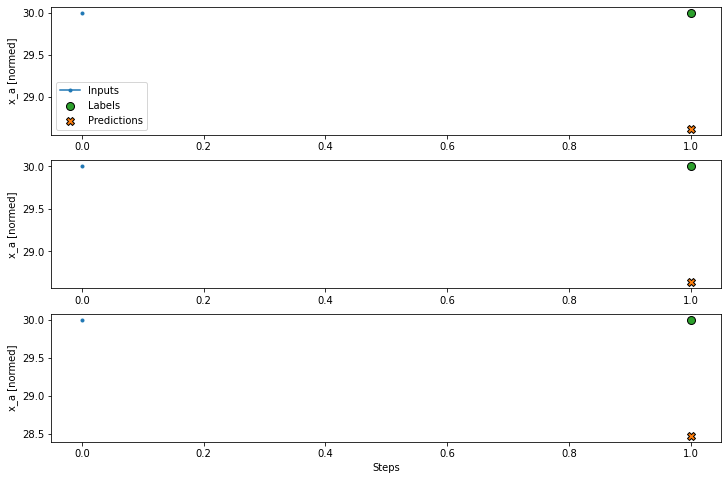

In [7]:
moving_label_window.plot(lstm_moving_model)

In [ ]:
keras.models.save_model(lstm_moving_model, "./Models/{}".format(savename))

In [ ]:
wide_window = WindowGenerator(input_width=40, label_width=40, shift=20,
                              label_columns=["x_a", "y_a", "x_d", "y_d", "firing"])
# feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(100, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=5)
])

# prediction, state = feedback_model.warmup(multi_window.example[0])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(wide_window.example)

## Train

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
multi_val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
multi_performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

wide_window.plot(lstm_model)

In [ ]:
keras.models.save_model(lstm_model, "./Models/lstm_100-Dense_5-Step-20")

In [ ]:
multi_window = WindowGenerator(input_width=20,label_width=20,shift=20)
multi_window.plot()

In [ ]:
feedback_model = FeedBack(units=100, out_steps=20)


history = compile_and_fit(feedback_model, multi_window)

In [ ]:
multi_val_performance['Feedback_model'] =feedback_model.evaluate(multi_window.val)
multi_performance['Feedback_model'] =feedback_model.evaluate(multi_window.test, verbose=0)

In [ ]:
multi_window.plot(feedback_model, plot_col="y_a")

In [ ]:
keras.models.save_model(feedback_model , "./Models/feedback_100-Dense_5-Step-20")

In [ ]:
wide_window.plot(lstm_model, plot_col="y_a")
plt.show()

## Compare

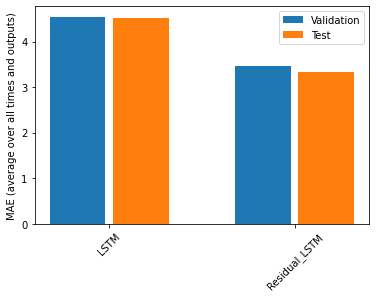

In [25]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()


def plot_from_to(df, y="reward", y2="level", start=0, end=1000000):
    fig, ax1 = plt.subplots()
    df.plot.scatter(x="Index", y=y, s=5, ax=ax1)
    plt.axis([start, end, 1, 2500])
    ax2 = ax1.twinx()
    df.plot.scatter(x="Index", y=y2, c="red", s=5, ax=ax2)
    plt.axis([start, end, 1, 12])
    fig.tight_layout()
    plt.show()


